# 3D Multi-organ Segmentation with Swin UNETR 

# Pre-trained Swin UNETR Encoder

We use weights from self-supervised pre-training of Swin UNETR encoder (3D Swin Tranformer) on a cohort of 5050 CT scans from publicly available datasets. The encoder is pre-trained using reconstructin, rotation prediction and contrastive learning pre-text tasks as shown below. For more details, please refer to [1] (CVPR paper) and see this [repository](https://github.com/Project-MONAI/research-contributions/tree/main/SwinUNETR/Pretrain). 

![image](https://lh3.googleusercontent.com/pw/AM-JKLVLgduGZ9naCSasWg09U665NBdd3UD4eLTy15wJiwbmKLS_p5WSZ2MBcRePEJO2tv9X3TkC52MsbnomuPy5JT3vSVeCji1MOEuAzcsxily88TdbHuAt6PzccefwKupbXyOCumK5hzz5Ul38kZnlEQ84=w397-h410-no?authuser=2)

Please download the pre-trained weights from this [link](https://github.com/Project-MONAI/MONAI-extra-test-data/releases/download/0.8.1/model_swinvit.pt) and place it in the root directory of this tutorial. 

If training from scratch is desired, please skip the step for initializing from pre-trained weights. 

## Setup environment

In [4]:

!python -c "import monai; import nibabel; import tqdm" || pip install -q "monai-weekly[nibabel, tqdm]"
!python -c "import matplotlib" || pip install -q matplotlib
%matplotlib inline


In [5]:
import os
import shutil
import tempfile

import matplotlib.pyplot as plt
from tqdm import tqdm

from monai.losses import DiceCELoss
from monai.inferers import sliding_window_inference
from monai.transforms import (
    AsDiscrete,
    Compose,
    CropForegroundd,
    LoadImaged,
    Orientationd,
    RandFlipd,
    RandCropByPosNegLabeld,
    RandShiftIntensityd,
    ScaleIntensityRanged,
    Spacingd,
    RandRotate90d,
    EnsureTyped,
)

from monai.config import print_config
from monai.metrics import DiceMetric
from monai.networks.nets import SwinUNETR

from monai.data import (
    ThreadDataLoader,
    CacheDataset,
    load_decathlon_datalist,
    decollate_batch,
    set_track_meta,
)


import torch

print_config()

MONAI version: 1.3.2
Numpy version: 1.23.1
Pytorch version: 1.12.1
MONAI flags: HAS_EXT = False, USE_COMPILED = False, USE_META_DICT = False
MONAI rev id: 59a7211070538586369afd4a01eca0a7fe2e742e
MONAI __file__: c:\Users\Dong\anaconda3\envs\dongpy\lib\site-packages\monai\__init__.py

Optional dependencies:
Pytorch Ignite version: NOT INSTALLED or UNKNOWN VERSION.
ITK version: NOT INSTALLED or UNKNOWN VERSION.
Nibabel version: 4.0.2
scikit-image version: 0.19.3
scipy version: 1.9.3
Pillow version: 9.2.0
Tensorboard version: 2.10.1
gdown version: NOT INSTALLED or UNKNOWN VERSION.
TorchVision version: 0.13.1
tqdm version: 4.64.1
lmdb version: NOT INSTALLED or UNKNOWN VERSION.
psutil version: 5.9.0
pandas version: 1.5.1
einops version: 0.5.0
transformers version: NOT INSTALLED or UNKNOWN VERSION.
mlflow version: 1.30.0
pynrrd version: 1.0.0
clearml version: NOT INSTALLED or UNKNOWN VERSION.

For details about installing the optional dependencies, please visit:
    https://docs.monai.io/en/

## Setup data directory

You can specify a directory with the `MONAI_DATA_DIRECTORY` environment variable.  
This allows you to save results and reuse downloads.  
If not specified a temporary directory will be used.

In [3]:
directory = os.environ.get("MONAI_DATA_DIRECTORY")
root_dir = tempfile.mkdtemp() if directory is None else directory
print(root_dir)

C:\Users\Dong\AppData\Local\Temp\tmp9n_h2tme


## Setup transforms for training and validation
To save on GPU memory utilization, the num_samples can be reduced to 2. 

A note on design related to MetaTensors:

- Summary: using `EnsureTyped(..., track_meta=False)` (caching) and `set_track_meta(False)` (during training) speeds up training significantly.

- We are moving towards the use of MONAI's MetaTensor in place of numpy arrays or PyTorch tensors. MetaTensors have the benefit of carrying the metadata directly with the tensor, but in some use cases (like here with training, where training data are only used for computing loss and metadata is not useful), we can safely disregard the metadata to improve speed.

- Hence, you will see `EnsureTyped` being used before the first random transform in the training transform chain, which caches the result of deterministic transforms on GPU as Tensors (rather than MetaTensors), with `track_meta = False`. 

- On the other hand, in the following demos we will display example validation images, which uses metadata, so we use `EnsureTyped` with `track_meta = True`. Since there are no random transforms during validation, tracking metadata for validation images causes virtually no slowdown (~0.5%).

- In the next section, you will see `set_track_meta(False)`. This is a global API introduced in MONAI 0.9.1, and it makes sure that random transforms will also be performed using Tensors rather than MetaTensors. Used together with `track_meta=False` in `EnsureTyped`, it results in all transforms being performed on Tensors, which we have found to speed up training.

In [6]:
num_samples = 4

os.environ["CUDA_DEVICE_ORDER"] = "PCI_BUS_ID"
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

train_transforms = Compose(
    [
        LoadImaged(keys=["image", "label"], ensure_channel_first=True),
        ScaleIntensityRanged(
            keys=["image"],
            a_min=-450,
            a_max=250,
            b_min=0.0,
            b_max=1.0,
            clip=True,
        ),
        CropForegroundd(keys=["image", "label"], source_key="image"),
        Orientationd(keys=["image", "label"], axcodes="RAS"),
        Spacingd(
            keys=["image", "label"],
            pixdim=(1.5, 1.5, 2.0),
            mode=("bilinear", "nearest"),
        ),
        
        RandCropByPosNegLabeld(
            keys=["image", "label"],
            label_key="label",
            spatial_size=(96, 96, 96),
            pos=1,
            neg=1,
            num_samples=num_samples,
            image_key="image",
            image_threshold=0,
        ),
        RandFlipd(
            keys=["image", "label"],
            spatial_axis=[0],
            prob=0.10,
        ),
        RandFlipd(
            keys=["image", "label"],
            spatial_axis=[1],
            prob=0.10,
        ),
        RandFlipd(
            keys=["image", "label"],
            spatial_axis=[2],
            prob=0.10,
        ),
        RandRotate90d(
            keys=["image", "label"],
            prob=0.10,
            max_k=3,
        ),
        RandShiftIntensityd(
            keys=["image"],
            offsets=0.10,
            prob=0.50,
        ),
        EnsureTyped(keys=["image", "label"], device=device, track_meta=False),
    ]
)
val_transforms = Compose(
    [
        LoadImaged(keys=["image", "label"], ensure_channel_first=True),
        ScaleIntensityRanged(
            keys=["image"], a_min=-450, a_max=250, b_min=0.0, b_max=1.0, clip=True
        ),
        CropForegroundd(keys=["image", "label"], source_key="image"),
        Orientationd(keys=["image", "label"], axcodes="RAS"),
        Spacingd(
            keys=["image", "label"],
            pixdim=(1.5, 1.5, 2.0),
            mode=("bilinear", "nearest"),
        ),
        EnsureTyped(keys=["image", "label"], device=device, track_meta=True),
    ]
)

c:\Users\Dong\anaconda3\envs\dongpy\lib\site-packages\monai\utils\deprecate_utils.py:321: FutureWarning: monai.transforms.croppad.dictionary CropForegroundd.__init__:allow_smaller: Current default value of argument `allow_smaller=True` has been deprecated since version 1.2. It will be changed to `allow_smaller=False` in version 1.5.
  warn_deprecated(argname, msg, warning_category)


## Download dataset and format in the folder
1. Download dataset from here: https://www.synapse.org/#!Synapse:syn3193805/wiki/89480. After you open the link, navigate to the "Files" tab, then download Abdomen/RawData.zip.

    Note that you may need to register for an account on Synapse and consent to use agreements before being able to view/download this file. There are options to download directly from the browser or from the command line; please refer to Synapse API documentation for more info.


2. After downloading the zip file, unzip. Then put images from `RawData/Training/img` in `./data/imagesTr`, and put labels from `RawData/Training/label` in `./data/labelsTr`.


3. Make a JSON file to define train/val split and other relevant parameters. Place the JSON file at `./data/dataset_0.json`.

    You can download an example of the JSON file [here](https://drive.google.com/file/d/1qcGh41p-rI3H_sQ0JwOAhNiQSXriQqGi/view?usp=sharing), or, equivalently, use the following `wget` command. If you would like to use this directly, please move it into the `./data` folder.

In [ ]:
# uncomment this command to download the JSON file directly
# wget -O data/dataset_0.json 'https://drive.google.com/uc?export=download&id=1qcGh41p-rI3H_sQ0JwOAhNiQSXriQqGi'

In [7]:
data_dir = "data_lymphoma_liver/"
split_JSON = "data_lymphoma_liver1.json"

datasets = data_dir + split_JSON
datalist = load_decathlon_datalist(datasets, True, "training")
val_files = load_decathlon_datalist(datasets, True, "validation")
test_files = load_decathlon_datalist(datasets, True, "test")

train_ds = CacheDataset(
    data=datalist,
    transform=train_transforms,
    cache_num=62,
    cache_rate=1.0,
    num_workers=8,
)
train_loader = ThreadDataLoader(train_ds, num_workers=0, batch_size=1, shuffle=True)
val_ds = CacheDataset(
    data=val_files, transform=val_transforms, cache_num=16, cache_rate=1.0, num_workers=4
)
val_loader = ThreadDataLoader(val_ds, num_workers=0, batch_size=1)

test_ds = CacheDataset(
    data=test_files, transform=val_transforms, cache_num=14, cache_rate=1.0, num_workers=4
)
test_loader = ThreadDataLoader(test_ds, num_workers=0, batch_size=1)

# as explained in the "Setup transforms" section above, we want cached training images to not have metadata, and validations to have metadata
# the EnsureTyped transforms allow us to make this distinction
# on the other hand, set_track_meta is a global API; doing so here makes sure subsequent transforms (i.e., random transforms for training)
# will be carried out as Tensors, not MetaTensors
set_track_meta(False)

Loading dataset: 100%|██████████| 14/14 [00:38<00:00,  2.75s/it]


In [8]:
print(len(train_ds))
print(len(val_ds))
print(len(test_ds))

62
16
14


## Check data shape and visualize

image shape: torch.Size([1, 244, 342, 164]), label shape: torch.Size([1, 244, 342, 164])


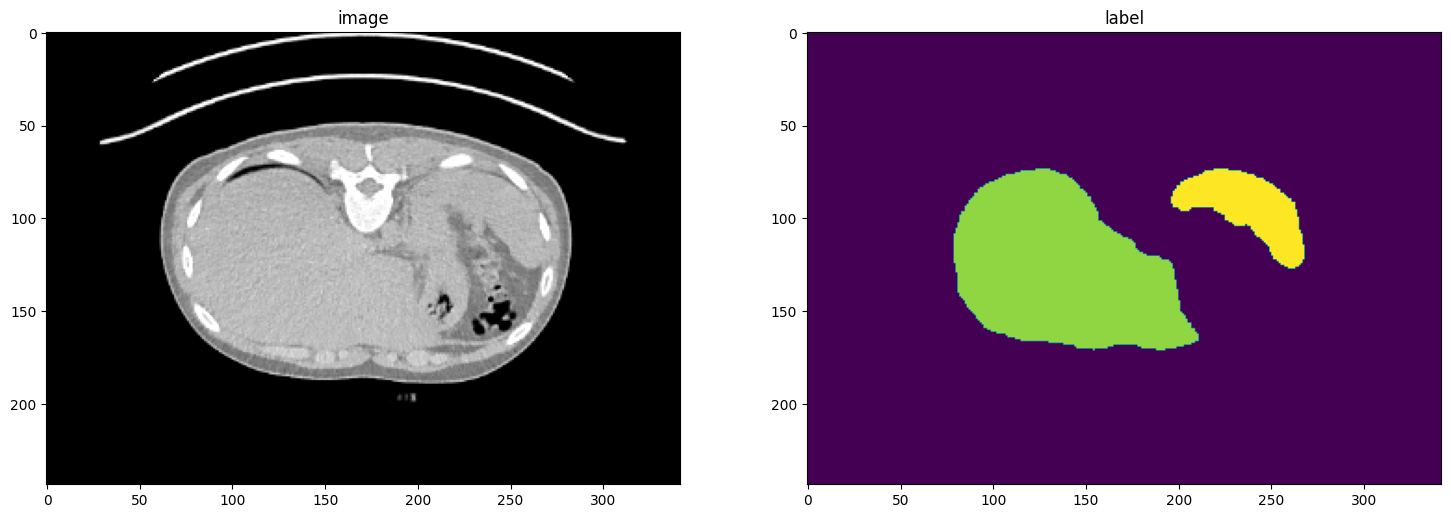

In [15]:

slice_map = {
    "CT95.nii.gz": 70,
    "CT96.nii.gz": 75,
    "CT97.nii.gz": 45,
    "CT99.nii.gz": 45,
    "CT100.nii.gz": 45,
    "CT101.nii.gz": 45,
}
case_num = 1
img_name = os.path.split(val_ds[case_num]['image'].meta["filename_or_obj"])[1]
img = val_ds[case_num]["image"]
label = val_ds[case_num]["label"]
img_shape = img.shape
label_shape = label.shape
print(f"image shape: {img_shape}, label shape: {label_shape}")
plt.figure("image", (18, 6))
plt.subplot(1, 2, 1)
plt.title("image")
plt.imshow(img[0, :, :, slice_map[img_name]].detach().cpu(), cmap="gray")
#plt.imshow(img[0, :, :, slice_map.get(img_name, 0)].detach().cpu(), cmap="gray")
plt.subplot(1, 2, 2)
plt.title("label")
plt.imshow(label[0, :, :, slice_map[img_name]].detach().cpu())
plt.show()




### Create Swin UNETR model

In this section, we create a Swin UNETR model for the 14-class multi-organ segmentation. We use a feature size of 48, which is compatible with the self-supervised pre-trained weights. We also use gradient checkpointing (use_checkpoint) for more memory-efficient training. 

In [16]:
os.environ["CUDA_DEVICE_ORDER"] = "PCI_BUS_ID"
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

model = SwinUNETR(
    img_size=(96, 96, 96),
    in_channels=1,
    out_channels=8,
    feature_size=48,
    use_checkpoint=True,
).to(device)

c:\Users\Dong\anaconda3\envs\dongpy\lib\site-packages\monai\utils\deprecate_utils.py:221: FutureWarning: monai.networks.nets.swin_unetr SwinUNETR.__init__:img_size: Argument `img_size` has been deprecated since version 1.3. It will be removed in version 1.5. The img_size argument is not required anymore and checks on the input size are run during forward().
  warn_deprecated(argname, msg, warning_category)


### Initialize Swin UNETR encoder from self-supervised pre-trained weights

In this section, we intialize the Swin UNETR encoder from pre-trained weights. The weights can be downloaded using the wget command below, or by following [this link](https://github.com/Project-MONAI/MONAI-extra-test-data/releases/download/0.8.1/model_swinvit.pt) to GitHub. If training from scratch is desired, please skip this section.

In [ ]:
# uncomment to download the pre-trained weights
# !wget https://github.com/Project-MONAI/MONAI-extra-test-data/releases/download/0.8.1/model_swinvit.pt

In [ ]:
#weight = torch.load("./model_swinvit.pt")
#model.load_from(weights=weight)
#print("Using pretrained self-supervied Swin UNETR backbone weights !")

In [17]:
weight = torch.load("C:/Users/Dong/Desktop/Python/3d_segmentation/data_lymphoma_liver/best_metric_model_20250111.pth")
model.load_state_dict(weight)
#print("Using pretrained model weights from C:/Users/Dong/AppData/Local/Temp/tmpo3m9v1gj/best_metric_model.pth!")

<All keys matched successfully>

### Optimizer and loss function

In [18]:
torch.backends.cudnn.benchmark = True
loss_function = DiceCELoss(to_onehot_y=True, sigmoid=True)
optimizer = torch.optim.AdamW(model.parameters(), lr=1e-4, weight_decay=1e-5)
scaler = torch.cuda.amp.GradScaler()

### Execute a typical PyTorch training process

In [19]:
scaler = torch.cuda.amp.GradScaler() # Mixed Precision Training
amp = True # Mixed Precision Training

def validation(epoch_iterator_val):
    model.eval()
    with torch.no_grad():
        for step, batch in enumerate(epoch_iterator_val):
            val_inputs, val_labels = (batch["image"].cuda(), batch["label"].cuda())
            with torch.cuda.amp.autocast():
                val_outputs = sliding_window_inference(val_inputs, (96, 96, 96), 4, model)
            val_labels_list = decollate_batch(val_labels)
            val_labels_convert = [
                post_label(val_label_tensor) for val_label_tensor in val_labels_list
            ]
            val_outputs_list = decollate_batch(val_outputs)
            val_output_convert = [
                post_pred(val_pred_tensor) for val_pred_tensor in val_outputs_list
            ]
            dice_metric(y_pred=val_output_convert, y=val_labels_convert)
            epoch_iterator_val.set_description(
                "Validate (%d / %d Steps)" % (global_step, 10.0)
            )
        mean_dice_val = dice_metric.aggregate().item()
        dice_metric.reset()
    return mean_dice_val


def train(global_step, train_loader, dice_val_best, global_step_best):
    model.train()
    epoch_loss = 0
    step = 0
    epoch_iterator = tqdm(
        train_loader, desc="Training (X / X Steps) (loss=X.X)", dynamic_ncols=True
    )
    for step, batch in enumerate(epoch_iterator):
        step += 1
        x, y = (batch["image"].cuda(), batch["label"].cuda())

        if amp and scaler is not None:
            with torch.cuda.amp.autocast():
                logit_map = model(x)
                loss = loss_function(logit_map, y)
            scaler.scale(loss).backward()
            epoch_loss += loss.item()
            scaler.step(optimizer)
            scaler.update()
            
        else:
            logit_map = model(x)
            loss = loss_function(logit_map, y)
            loss.backward()
            epoch_loss += loss.item()
            optimizer.step()

        optimizer.zero_grad()
        epoch_iterator.set_description(
            "Training (%d / %d Steps) (loss=%2.5f)"
            % (global_step, max_iterations, loss)
        )
        # 메모리 사용량 확인
        #print("GPU memory allocated: ", torch.cuda.memory_allocated() / 1024 / 1024, "MB")
        #print("GPU max memory allocated: ", torch.cuda.max_memory_allocated() / 1024 / 1024, "MB")
        
        if (
            global_step % eval_num == 0 and global_step != 0
        ) or global_step == max_iterations:
            epoch_iterator_val = tqdm(
                val_loader, desc="Validate (X / X Steps) (dice=X.X)", dynamic_ncols=True
            )
            dice_val = validation(epoch_iterator_val)
            epoch_loss /= step
            epoch_loss_values.append(epoch_loss)
            metric_values.append(dice_val)
            if dice_val > dice_val_best:
                dice_val_best = dice_val
                global_step_best = global_step
                torch.save(
                    model.state_dict(), os.path.join(root_dir, "best_metric_model.pth")
                )
                print(
                    "Model Was Saved ! Current Best Avg. Dice: {} Current Avg. Dice: {}".format(
                        dice_val_best, dice_val
                    )
                )
            else:
                print(
                    "Model Was Not Saved ! Current Best Avg. Dice: {} Current Avg. Dice: {}".format(
                        dice_val_best, dice_val
                    )
                )
        global_step += 1
    return global_step, dice_val_best, global_step_best

In [9]:
max_iterations = 30000
drop_rate = 0.2
eval_num = 200
post_label = AsDiscrete(to_onehot=8)
post_pred = AsDiscrete(argmax=True, to_onehot=8)
dice_metric = DiceMetric(include_background=True, reduction="mean", get_not_nans=False)
global_step = 0
dice_val_best = 0.0
global_step_best = 0
epoch_loss_values = []
metric_values = []
while global_step < max_iterations:
    global_step, dice_val_best, global_step_best = train(
        global_step, train_loader, dice_val_best, global_step_best
    )
model.load_state_dict(torch.load(os.path.join(root_dir, "best_metric_model.pth")))

Training (X / X Steps) (loss=X.X):   0%|          | 0/62 [00:00<?, ?it/s]

Training (200 / 30000 Steps) (loss=1.34499):  24%|██▍       | 15/62 [00:57<11:09, 14.24s/it]

Model Was Saved ! Current Best Avg. Dice: 0.2141992151737213 Current Avg. Dice: 0.2141992151737213


Training (400 / 30000 Steps) (loss=1.19334):  47%|████▋     | 29/62 [01:06<07:17, 13.27s/it]

Model Was Saved ! Current Best Avg. Dice: 0.30392980575561523 Current Avg. Dice: 0.30392980575561523


Training (600 / 30000 Steps) (loss=1.00427):  69%|██████▉   | 43/62 [01:19<04:12, 13.28s/it]

Model Was Saved ! Current Best Avg. Dice: 0.4418299198150635 Current Avg. Dice: 0.4418299198150635


Training (800 / 30000 Steps) (loss=0.91979):  92%|█████████▏| 57/62 [01:31<01:06, 13.33s/it]

Model Was Saved ! Current Best Avg. Dice: 0.4928043484687805 Current Avg. Dice: 0.4928043484687805


Training (1000 / 30000 Steps) (loss=0.97136):  15%|█▍        | 9/62 [00:49<12:10, 13.78s/it]

Model Was Saved ! Current Best Avg. Dice: 0.5303295850753784 Current Avg. Dice: 0.5303295850753784


Training (1200 / 30000 Steps) (loss=0.84461):  37%|███▋      | 23/62 [01:01<08:39, 13.33s/it]

Model Was Saved ! Current Best Avg. Dice: 0.6151652336120605 Current Avg. Dice: 0.6151652336120605


Training (1400 / 30000 Steps) (loss=0.79666):  60%|█████▉    | 37/62 [01:13<05:29, 13.18s/it]

Model Was Saved ! Current Best Avg. Dice: 0.7002454400062561 Current Avg. Dice: 0.7002454400062561


Training (1600 / 30000 Steps) (loss=0.86697):  82%|████████▏ | 51/62 [01:27<02:31, 13.79s/it]

Model Was Saved ! Current Best Avg. Dice: 0.7319552898406982 Current Avg. Dice: 0.7319552898406982


Training (1800 / 30000 Steps) (loss=0.81266):   5%|▍         | 3/62 [00:44<19:26, 19.77s/it]

Model Was Saved ! Current Best Avg. Dice: 0.736717700958252 Current Avg. Dice: 0.736717700958252


Training (2000 / 30000 Steps) (loss=0.70032):  27%|██▋       | 17/62 [00:49<08:20, 11.12s/it]

Model Was Saved ! Current Best Avg. Dice: 0.7443109750747681 Current Avg. Dice: 0.7443109750747681


Training (2200 / 30000 Steps) (loss=1.05739):  50%|█████     | 31/62 [01:08<06:45, 13.07s/it]

Model Was Saved ! Current Best Avg. Dice: 0.7602077722549438 Current Avg. Dice: 0.7602077722549438


Training (2400 / 30000 Steps) (loss=0.88622):  73%|███████▎  | 45/62 [01:18<03:37, 12.79s/it]

Model Was Not Saved ! Current Best Avg. Dice: 0.7602077722549438 Current Avg. Dice: 0.710157573223114


Training (2600 / 30000 Steps) (loss=0.63709):  95%|█████████▌| 59/62 [01:30<00:38, 12.89s/it]

Model Was Saved ! Current Best Avg. Dice: 0.7849568128585815 Current Avg. Dice: 0.7849568128585815


Training (2800 / 30000 Steps) (loss=0.75688):  18%|█▊        | 11/62 [00:50<11:17, 13.29s/it]

Model Was Saved ! Current Best Avg. Dice: 0.7922551035881042 Current Avg. Dice: 0.7922551035881042


Training (3000 / 30000 Steps) (loss=0.59520):  40%|████      | 25/62 [01:02<08:03, 13.06s/it]

Model Was Saved ! Current Best Avg. Dice: 0.7933346033096313 Current Avg. Dice: 0.7933346033096313


Training (3200 / 30000 Steps) (loss=0.61075):  63%|██████▎   | 39/62 [01:13<04:55, 12.83s/it]

Model Was Not Saved ! Current Best Avg. Dice: 0.7933346033096313 Current Avg. Dice: 0.7897729277610779


Training (3400 / 30000 Steps) (loss=0.64612):  85%|████████▌ | 53/62 [01:26<01:57, 13.01s/it]

Model Was Saved ! Current Best Avg. Dice: 0.8020433187484741 Current Avg. Dice: 0.8020433187484741


Training (3600 / 30000 Steps) (loss=0.61241):   8%|▊         | 5/62 [00:44<14:43, 15.50s/it]

Model Was Saved ! Current Best Avg. Dice: 0.8070894479751587 Current Avg. Dice: 0.8070894479751587


Training (3800 / 30000 Steps) (loss=0.62928):  31%|███       | 19/62 [00:56<09:17, 12.97s/it]

Model Was Saved ! Current Best Avg. Dice: 0.85316002368927 Current Avg. Dice: 0.85316002368927


Training (4000 / 30000 Steps) (loss=0.68216):  53%|█████▎    | 33/62 [01:08<06:12, 12.84s/it]

Model Was Not Saved ! Current Best Avg. Dice: 0.85316002368927 Current Avg. Dice: 0.8223421573638916


Training (4200 / 30000 Steps) (loss=0.65829):  76%|███████▌  | 47/62 [01:20<03:15, 13.05s/it]

Model Was Saved ! Current Best Avg. Dice: 0.8585361242294312 Current Avg. Dice: 0.8585361242294312


Training (4400 / 30000 Steps) (loss=0.49133):  98%|█████████▊| 61/62 [01:24<00:10, 10.64s/it]

Model Was Not Saved ! Current Best Avg. Dice: 0.8585361242294312 Current Avg. Dice: 0.8314061164855957


Training (4600 / 30000 Steps) (loss=0.72644):  21%|██        | 13/62 [00:44<09:19, 11.43s/it]

Model Was Saved ! Current Best Avg. Dice: 0.8740039467811584 Current Avg. Dice: 0.8740039467811584


Training (4800 / 30000 Steps) (loss=0.65774):  44%|████▎     | 27/62 [00:51<06:04, 10.41s/it]

Model Was Not Saved ! Current Best Avg. Dice: 0.8740039467811584 Current Avg. Dice: 0.868514895439148


Training (5000 / 30000 Steps) (loss=0.56996):  66%|██████▌   | 41/62 [01:02<03:49, 10.92s/it]

Model Was Saved ! Current Best Avg. Dice: 0.8848991394042969 Current Avg. Dice: 0.8848991394042969


Training (5200 / 30000 Steps) (loss=0.75457):  89%|████████▊ | 55/62 [01:12<01:14, 10.63s/it]

Model Was Saved ! Current Best Avg. Dice: 0.8858110904693604 Current Avg. Dice: 0.8858110904693604


Training (5400 / 30000 Steps) (loss=0.58546):  11%|█▏        | 7/62 [00:38<10:42, 11.69s/it]

Model Was Saved ! Current Best Avg. Dice: 0.8981879949569702 Current Avg. Dice: 0.8981879949569702


Training (5600 / 30000 Steps) (loss=0.58792):  34%|███▍      | 21/62 [00:48<07:12, 10.54s/it]

Model Was Not Saved ! Current Best Avg. Dice: 0.8981879949569702 Current Avg. Dice: 0.8892773389816284


Training (5800 / 30000 Steps) (loss=0.73502):  56%|█████▋    | 35/62 [00:57<04:46, 10.62s/it]

Model Was Saved ! Current Best Avg. Dice: 0.9045754075050354 Current Avg. Dice: 0.9045754075050354


Training (6000 / 30000 Steps) (loss=0.59062):  79%|███████▉  | 49/62 [01:07<02:17, 10.61s/it]

Model Was Not Saved ! Current Best Avg. Dice: 0.9045754075050354 Current Avg. Dice: 0.8941584825515747


Training (6200 / 30000 Steps) (loss=0.62921):   2%|▏         | 1/62 [00:33<34:23, 33.83s/it]

Model Was Not Saved ! Current Best Avg. Dice: 0.9045754075050354 Current Avg. Dice: 0.8981705904006958


Training (6400 / 30000 Steps) (loss=0.51248):  24%|██▍       | 15/62 [00:43<08:11, 10.47s/it]

Model Was Not Saved ! Current Best Avg. Dice: 0.9045754075050354 Current Avg. Dice: 0.8916205763816833


Training (6600 / 30000 Steps) (loss=0.62839):  47%|████▋     | 29/62 [00:53<05:53, 10.71s/it]

Model Was Not Saved ! Current Best Avg. Dice: 0.9045754075050354 Current Avg. Dice: 0.9032210111618042


Training (6800 / 30000 Steps) (loss=0.68782):  69%|██████▉   | 43/62 [01:03<03:19, 10.51s/it]

Model Was Not Saved ! Current Best Avg. Dice: 0.9045754075050354 Current Avg. Dice: 0.891218900680542


Training (7000 / 30000 Steps) (loss=0.72481):  92%|█████████▏| 57/62 [01:13<00:53, 10.61s/it]

Model Was Not Saved ! Current Best Avg. Dice: 0.9045754075050354 Current Avg. Dice: 0.887298583984375


Training (7200 / 30000 Steps) (loss=0.50591):  15%|█▍        | 9/62 [00:39<09:42, 10.99s/it]

Model Was Not Saved ! Current Best Avg. Dice: 0.9045754075050354 Current Avg. Dice: 0.8871637582778931


Training (7400 / 30000 Steps) (loss=0.64259):  37%|███▋      | 23/62 [00:48<06:50, 10.52s/it]

Model Was Not Saved ! Current Best Avg. Dice: 0.9045754075050354 Current Avg. Dice: 0.8969345092773438


Training (7600 / 30000 Steps) (loss=0.45866):  60%|█████▉    | 37/62 [00:58<04:20, 10.41s/it]

Model Was Not Saved ! Current Best Avg. Dice: 0.9045754075050354 Current Avg. Dice: 0.9015640020370483


Training (7800 / 30000 Steps) (loss=0.64815):  82%|████████▏ | 51/62 [01:10<01:58, 10.81s/it]

Model Was Saved ! Current Best Avg. Dice: 0.9128209948539734 Current Avg. Dice: 0.9128209948539734


Training (8000 / 30000 Steps) (loss=0.60126):   5%|▍         | 3/62 [00:34<15:19, 15.59s/it]

Model Was Not Saved ! Current Best Avg. Dice: 0.9128209948539734 Current Avg. Dice: 0.9046212434768677


Training (8200 / 30000 Steps) (loss=0.52499):  27%|██▋       | 17/62 [00:45<08:03, 10.73s/it]

Model Was Not Saved ! Current Best Avg. Dice: 0.9128209948539734 Current Avg. Dice: 0.8767433166503906


Training (8400 / 30000 Steps) (loss=0.60942):  50%|█████     | 31/62 [00:55<05:26, 10.52s/it]

Model Was Not Saved ! Current Best Avg. Dice: 0.9128209948539734 Current Avg. Dice: 0.9049392938613892


Training (8600 / 30000 Steps) (loss=0.40612):  73%|███████▎  | 45/62 [01:04<02:59, 10.56s/it]

Model Was Saved ! Current Best Avg. Dice: 0.9140543937683105 Current Avg. Dice: 0.9140543937683105


Training (8800 / 30000 Steps) (loss=0.46104):  95%|█████████▌| 59/62 [01:14<00:31, 10.61s/it]

Model Was Not Saved ! Current Best Avg. Dice: 0.9140543937683105 Current Avg. Dice: 0.9074045419692993


Training (9000 / 30000 Steps) (loss=0.55747):  18%|█▊        | 11/62 [00:41<09:16, 10.91s/it]

Model Was Saved ! Current Best Avg. Dice: 0.9164154529571533 Current Avg. Dice: 0.9164154529571533


Training (9200 / 30000 Steps) (loss=0.51163):  40%|████      | 25/62 [00:50<06:34, 10.66s/it]

Model Was Not Saved ! Current Best Avg. Dice: 0.9164154529571533 Current Avg. Dice: 0.9107216596603394


Training (9400 / 30000 Steps) (loss=0.57868):  63%|██████▎   | 39/62 [01:00<04:04, 10.65s/it]

Model Was Not Saved ! Current Best Avg. Dice: 0.9164154529571533 Current Avg. Dice: 0.9153643846511841


Training (9600 / 30000 Steps) (loss=0.58479):  85%|████████▌ | 53/62 [01:10<01:34, 10.48s/it]

Model Was Not Saved ! Current Best Avg. Dice: 0.9164154529571533 Current Avg. Dice: 0.9141691327095032


Training (9800 / 30000 Steps) (loss=0.72967):   8%|▊         | 5/62 [00:37<12:15, 12.90s/it]

Model Was Saved ! Current Best Avg. Dice: 0.9190888404846191 Current Avg. Dice: 0.9190888404846191


Training (10000 / 30000 Steps) (loss=0.61138):  31%|███       | 19/62 [00:46<07:31, 10.50s/it]

Model Was Not Saved ! Current Best Avg. Dice: 0.9190888404846191 Current Avg. Dice: 0.909096360206604


Training (10200 / 30000 Steps) (loss=0.47128):  53%|█████▎    | 33/62 [00:55<05:01, 10.40s/it]

Model Was Not Saved ! Current Best Avg. Dice: 0.9190888404846191 Current Avg. Dice: 0.8910186886787415


Training (10400 / 30000 Steps) (loss=0.48544):  76%|███████▌  | 47/62 [01:06<02:42, 10.83s/it]

Model Was Saved ! Current Best Avg. Dice: 0.9216918349266052 Current Avg. Dice: 0.9216918349266052


Training (10600 / 30000 Steps) (loss=0.44444):  98%|█████████▊| 61/62 [01:16<00:10, 10.51s/it]

Model Was Not Saved ! Current Best Avg. Dice: 0.9216918349266052 Current Avg. Dice: 0.8966794013977051


Training (10800 / 30000 Steps) (loss=0.78513):  21%|██        | 13/62 [00:42<08:47, 10.77s/it]

Model Was Not Saved ! Current Best Avg. Dice: 0.9216918349266052 Current Avg. Dice: 0.9150211811065674


Training (11000 / 30000 Steps) (loss=0.58727):  44%|████▎     | 27/62 [00:52<06:10, 10.60s/it]

Model Was Not Saved ! Current Best Avg. Dice: 0.9216918349266052 Current Avg. Dice: 0.9085333347320557


Training (11200 / 30000 Steps) (loss=0.45270):  66%|██████▌   | 41/62 [01:02<03:38, 10.40s/it]

Model Was Not Saved ! Current Best Avg. Dice: 0.9216918349266052 Current Avg. Dice: 0.9095134735107422


Training (11400 / 30000 Steps) (loss=0.71560):  89%|████████▊ | 55/62 [01:12<01:15, 10.83s/it]

Model Was Saved ! Current Best Avg. Dice: 0.9230553507804871 Current Avg. Dice: 0.9230553507804871


Training (11600 / 30000 Steps) (loss=0.54913):  11%|█▏        | 7/62 [00:38<10:38, 11.62s/it]

Model Was Not Saved ! Current Best Avg. Dice: 0.9230553507804871 Current Avg. Dice: 0.918745756149292


Training (11800 / 30000 Steps) (loss=0.63231):  34%|███▍      | 21/62 [00:47<07:17, 10.66s/it]

Model Was Saved ! Current Best Avg. Dice: 0.9231560826301575 Current Avg. Dice: 0.9231560826301575


Training (12000 / 30000 Steps) (loss=0.57384):  56%|█████▋    | 35/62 [00:57<04:46, 10.63s/it]

Model Was Not Saved ! Current Best Avg. Dice: 0.9231560826301575 Current Avg. Dice: 0.9118053913116455


Training (12200 / 30000 Steps) (loss=0.46005):  79%|███████▉  | 49/62 [01:08<02:18, 10.69s/it]

Model Was Saved ! Current Best Avg. Dice: 0.9246190190315247 Current Avg. Dice: 0.9246190190315247


Training (12400 / 30000 Steps) (loss=0.45804):   2%|▏         | 1/62 [00:33<34:28, 33.91s/it]

Model Was Not Saved ! Current Best Avg. Dice: 0.9246190190315247 Current Avg. Dice: 0.9174156188964844


Training (12600 / 30000 Steps) (loss=0.42822):  24%|██▍       | 15/62 [00:42<08:10, 10.44s/it]

Model Was Not Saved ! Current Best Avg. Dice: 0.9246190190315247 Current Avg. Dice: 0.9197766780853271


Training (12800 / 30000 Steps) (loss=0.40486):  47%|████▋     | 29/62 [00:54<05:52, 10.68s/it]

Model Was Not Saved ! Current Best Avg. Dice: 0.9246190190315247 Current Avg. Dice: 0.9222922325134277


Training (13000 / 30000 Steps) (loss=0.65724):  69%|██████▉   | 43/62 [01:03<03:19, 10.51s/it]

Model Was Not Saved ! Current Best Avg. Dice: 0.9246190190315247 Current Avg. Dice: 0.9043339490890503


Training (13200 / 30000 Steps) (loss=0.34572):  92%|█████████▏| 57/62 [01:14<00:54, 10.92s/it]

Model Was Saved ! Current Best Avg. Dice: 0.9303145408630371 Current Avg. Dice: 0.9303145408630371


Training (13400 / 30000 Steps) (loss=0.73956):  15%|█▍        | 9/62 [00:38<09:33, 10.83s/it]

Model Was Not Saved ! Current Best Avg. Dice: 0.9303145408630371 Current Avg. Dice: 0.9266129732131958


Training (13600 / 30000 Steps) (loss=0.56030):  37%|███▋      | 23/62 [00:49<06:53, 10.61s/it]

Model Was Not Saved ! Current Best Avg. Dice: 0.9303145408630371 Current Avg. Dice: 0.9188562631607056


Training (13800 / 30000 Steps) (loss=0.68256):  60%|█████▉    | 37/62 [00:59<04:28, 10.73s/it]

Model Was Not Saved ! Current Best Avg. Dice: 0.9303145408630371 Current Avg. Dice: 0.9091893434524536


Training (14000 / 30000 Steps) (loss=0.47763):  82%|████████▏ | 51/62 [01:09<01:55, 10.52s/it]

Model Was Not Saved ! Current Best Avg. Dice: 0.9303145408630371 Current Avg. Dice: 0.9153976440429688


Training (14200 / 30000 Steps) (loss=0.52677):   5%|▍         | 3/62 [00:35<15:33, 15.82s/it]

Model Was Not Saved ! Current Best Avg. Dice: 0.9303145408630371 Current Avg. Dice: 0.9263458847999573


Training (14400 / 30000 Steps) (loss=0.48877):  27%|██▋       | 17/62 [00:45<08:00, 10.69s/it]

Model Was Not Saved ! Current Best Avg. Dice: 0.9303145408630371 Current Avg. Dice: 0.9228367805480957


Training (14600 / 30000 Steps) (loss=0.37094):  50%|█████     | 31/62 [00:55<05:25, 10.51s/it]

Model Was Not Saved ! Current Best Avg. Dice: 0.9303145408630371 Current Avg. Dice: 0.9098562002182007


Training (14800 / 30000 Steps) (loss=0.41971):  73%|███████▎  | 45/62 [01:04<03:01, 10.66s/it]

Model Was Not Saved ! Current Best Avg. Dice: 0.9303145408630371 Current Avg. Dice: 0.9173516035079956


Training (15000 / 30000 Steps) (loss=0.53939):  95%|█████████▌| 59/62 [01:14<00:31, 10.54s/it]

Model Was Not Saved ! Current Best Avg. Dice: 0.9303145408630371 Current Avg. Dice: 0.9275487661361694


Training (15200 / 30000 Steps) (loss=0.48983):  18%|█▊        | 11/62 [00:40<09:00, 10.60s/it]

Model Was Not Saved ! Current Best Avg. Dice: 0.9303145408630371 Current Avg. Dice: 0.9234483242034912


Training (15400 / 30000 Steps) (loss=0.44793):  40%|████      | 25/62 [00:51<06:37, 10.73s/it]

Model Was Not Saved ! Current Best Avg. Dice: 0.9303145408630371 Current Avg. Dice: 0.9217900633811951


Training (15600 / 30000 Steps) (loss=0.51406):  63%|██████▎   | 39/62 [01:00<04:01, 10.51s/it]

Model Was Not Saved ! Current Best Avg. Dice: 0.9303145408630371 Current Avg. Dice: 0.9147730469703674


Training (15800 / 30000 Steps) (loss=0.63403):  85%|████████▌ | 53/62 [01:10<01:36, 10.68s/it]

Model Was Not Saved ! Current Best Avg. Dice: 0.9303145408630371 Current Avg. Dice: 0.9162055850028992


Training (16000 / 30000 Steps) (loss=0.34180):   8%|▊         | 5/62 [00:36<11:59, 12.62s/it]

Model Was Not Saved ! Current Best Avg. Dice: 0.9303145408630371 Current Avg. Dice: 0.9222855567932129


Training (16200 / 30000 Steps) (loss=0.41639):  31%|███       | 19/62 [00:46<07:30, 10.47s/it]

Model Was Not Saved ! Current Best Avg. Dice: 0.9303145408630371 Current Avg. Dice: 0.9240468144416809


Training (16400 / 30000 Steps) (loss=0.49262):  53%|█████▎    | 33/62 [00:56<05:06, 10.56s/it]

Model Was Not Saved ! Current Best Avg. Dice: 0.9303145408630371 Current Avg. Dice: 0.9252637624740601


Training (16600 / 30000 Steps) (loss=0.51337):  76%|███████▌  | 47/62 [01:06<02:39, 10.65s/it]

Model Was Not Saved ! Current Best Avg. Dice: 0.9303145408630371 Current Avg. Dice: 0.9213175773620605


Training (16800 / 30000 Steps) (loss=0.52074):  98%|█████████▊| 61/62 [01:16<00:10, 10.39s/it]

Model Was Not Saved ! Current Best Avg. Dice: 0.9303145408630371 Current Avg. Dice: 0.9190623760223389


Training (17000 / 30000 Steps) (loss=0.45388):  21%|██        | 13/62 [00:42<08:45, 10.72s/it]

Model Was Not Saved ! Current Best Avg. Dice: 0.9303145408630371 Current Avg. Dice: 0.923776388168335


Training (17200 / 30000 Steps) (loss=0.45338):  44%|████▎     | 27/62 [00:52<06:06, 10.48s/it]

Model Was Not Saved ! Current Best Avg. Dice: 0.9303145408630371 Current Avg. Dice: 0.9250677824020386


Training (17400 / 30000 Steps) (loss=0.43598):  66%|██████▌   | 41/62 [01:01<03:41, 10.56s/it]

Model Was Not Saved ! Current Best Avg. Dice: 0.9303145408630371 Current Avg. Dice: 0.9291610717773438


Training (17600 / 30000 Steps) (loss=0.52927):  89%|████████▊ | 55/62 [01:13<01:15, 10.77s/it]

Model Was Not Saved ! Current Best Avg. Dice: 0.9303145408630371 Current Avg. Dice: 0.9082876443862915


Training (17800 / 30000 Steps) (loss=0.43928):  11%|█▏        | 7/62 [00:38<10:32, 11.50s/it]

Model Was Not Saved ! Current Best Avg. Dice: 0.9303145408630371 Current Avg. Dice: 0.9187526702880859


Training (18000 / 30000 Steps) (loss=0.49000):  34%|███▍      | 21/62 [00:47<07:06, 10.41s/it]

Model Was Not Saved ! Current Best Avg. Dice: 0.9303145408630371 Current Avg. Dice: 0.900616466999054


Training (18200 / 30000 Steps) (loss=0.59786):  56%|█████▋    | 35/62 [00:58<04:49, 10.72s/it]

Model Was Not Saved ! Current Best Avg. Dice: 0.9303145408630371 Current Avg. Dice: 0.9183464050292969


Training (18400 / 30000 Steps) (loss=0.59689):  79%|███████▉  | 49/62 [01:07<02:16, 10.52s/it]

Model Was Not Saved ! Current Best Avg. Dice: 0.9303145408630371 Current Avg. Dice: 0.9262198209762573


Training (18600 / 30000 Steps) (loss=0.53766):   2%|▏         | 1/62 [00:33<34:27, 33.89s/it]

Model Was Not Saved ! Current Best Avg. Dice: 0.9303145408630371 Current Avg. Dice: 0.9116116762161255


Training (18800 / 30000 Steps) (loss=0.64092):  24%|██▍       | 15/62 [00:43<08:21, 10.66s/it]

Model Was Not Saved ! Current Best Avg. Dice: 0.9303145408630371 Current Avg. Dice: 0.9264728426933289


Training (19000 / 30000 Steps) (loss=0.50298):  47%|████▋     | 29/62 [00:52<05:43, 10.40s/it]

Model Was Not Saved ! Current Best Avg. Dice: 0.9303145408630371 Current Avg. Dice: 0.9226453900337219


Training (19200 / 30000 Steps) (loss=0.49012):  69%|██████▉   | 43/62 [01:03<03:22, 10.64s/it]

Model Was Not Saved ! Current Best Avg. Dice: 0.9303145408630371 Current Avg. Dice: 0.9226068258285522


Training (19400 / 30000 Steps) (loss=0.43343):  92%|█████████▏| 57/62 [01:13<00:53, 10.68s/it]

Model Was Not Saved ! Current Best Avg. Dice: 0.9303145408630371 Current Avg. Dice: 0.9296684861183167


Training (19600 / 30000 Steps) (loss=0.70771):  15%|█▍        | 9/62 [00:39<09:39, 10.94s/it]

Model Was Not Saved ! Current Best Avg. Dice: 0.9303145408630371 Current Avg. Dice: 0.9288567900657654


Training (19800 / 30000 Steps) (loss=0.62338):  37%|███▋      | 23/62 [00:49<07:01, 10.81s/it]

Model Was Saved ! Current Best Avg. Dice: 0.9303817749023438 Current Avg. Dice: 0.9303817749023438


Training (20000 / 30000 Steps) (loss=0.44209):  60%|█████▉    | 37/62 [00:59<04:20, 10.41s/it]

Model Was Not Saved ! Current Best Avg. Dice: 0.9303817749023438 Current Avg. Dice: 0.9275417923927307


Training (20200 / 30000 Steps) (loss=0.34934):  82%|████████▏ | 51/62 [01:09<01:55, 10.47s/it]

Model Was Not Saved ! Current Best Avg. Dice: 0.9303817749023438 Current Avg. Dice: 0.9268822073936462


Training (20400 / 30000 Steps) (loss=0.58837):   5%|▍         | 3/62 [00:35<15:43, 16.00s/it]

Model Was Not Saved ! Current Best Avg. Dice: 0.9303817749023438 Current Avg. Dice: 0.9192521572113037


Training (20600 / 30000 Steps) (loss=0.59807):  27%|██▋       | 17/62 [00:44<07:53, 10.53s/it]

Model Was Not Saved ! Current Best Avg. Dice: 0.9303817749023438 Current Avg. Dice: 0.922123372554779


Training (20800 / 30000 Steps) (loss=0.47736):  50%|█████     | 31/62 [00:55<05:34, 10.80s/it]

Model Was Saved ! Current Best Avg. Dice: 0.9326611757278442 Current Avg. Dice: 0.9326611757278442


Training (21000 / 30000 Steps) (loss=0.51226):  73%|███████▎  | 45/62 [01:05<02:56, 10.41s/it]

Model Was Not Saved ! Current Best Avg. Dice: 0.9326611757278442 Current Avg. Dice: 0.9308870434761047


Training (21200 / 30000 Steps) (loss=0.48995):  95%|█████████▌| 59/62 [01:15<00:31, 10.50s/it]

Model Was Not Saved ! Current Best Avg. Dice: 0.9326611757278442 Current Avg. Dice: 0.9249377846717834


Training (21400 / 30000 Steps) (loss=0.63239):  18%|█▊        | 11/62 [00:40<09:06, 10.71s/it]

Model Was Not Saved ! Current Best Avg. Dice: 0.9326611757278442 Current Avg. Dice: 0.9245378971099854


Training (21600 / 30000 Steps) (loss=0.54255):  40%|████      | 25/62 [00:51<06:33, 10.62s/it]

Model Was Not Saved ! Current Best Avg. Dice: 0.9326611757278442 Current Avg. Dice: 0.9268990159034729


Training (21800 / 30000 Steps) (loss=0.45234):  63%|██████▎   | 39/62 [01:00<04:00, 10.44s/it]

Model Was Not Saved ! Current Best Avg. Dice: 0.9326611757278442 Current Avg. Dice: 0.9258916974067688


Training (22000 / 30000 Steps) (loss=0.54112):  85%|████████▌ | 53/62 [01:10<01:36, 10.68s/it]

Model Was Not Saved ! Current Best Avg. Dice: 0.9326611757278442 Current Avg. Dice: 0.924422562122345


Training (22200 / 30000 Steps) (loss=0.42811):   8%|▊         | 5/62 [00:36<11:49, 12.44s/it]

Model Was Not Saved ! Current Best Avg. Dice: 0.9326611757278442 Current Avg. Dice: 0.9274790287017822


Training (22400 / 30000 Steps) (loss=0.42752):  31%|███       | 19/62 [00:46<07:32, 10.52s/it]

Model Was Not Saved ! Current Best Avg. Dice: 0.9326611757278442 Current Avg. Dice: 0.924785852432251


Training (22600 / 30000 Steps) (loss=0.53292):  53%|█████▎    | 33/62 [00:56<05:09, 10.67s/it]

Model Was Not Saved ! Current Best Avg. Dice: 0.9326611757278442 Current Avg. Dice: 0.9254224300384521


Training (22800 / 30000 Steps) (loss=0.41947):  76%|███████▌  | 47/62 [01:06<02:37, 10.52s/it]

Model Was Not Saved ! Current Best Avg. Dice: 0.9326611757278442 Current Avg. Dice: 0.9282909035682678


Training (23000 / 30000 Steps) (loss=0.28725):  98%|█████████▊| 61/62 [01:16<00:10, 10.51s/it]

Model Was Not Saved ! Current Best Avg. Dice: 0.9326611757278442 Current Avg. Dice: 0.9315719604492188


Training (23200 / 30000 Steps) (loss=0.53952):  21%|██        | 13/62 [00:42<08:46, 10.74s/it]

Model Was Not Saved ! Current Best Avg. Dice: 0.9326611757278442 Current Avg. Dice: 0.9157501459121704


Training (23400 / 30000 Steps) (loss=0.48009):  44%|████▎     | 27/62 [00:52<06:04, 10.41s/it]

Model Was Not Saved ! Current Best Avg. Dice: 0.9326611757278442 Current Avg. Dice: 0.9240328073501587


Training (23600 / 30000 Steps) (loss=0.53507):  66%|██████▌   | 41/62 [01:02<03:43, 10.65s/it]

Model Was Not Saved ! Current Best Avg. Dice: 0.9326611757278442 Current Avg. Dice: 0.9173641800880432


Training (23800 / 30000 Steps) (loss=0.55538):  89%|████████▊ | 55/62 [01:11<01:13, 10.51s/it]

Model Was Not Saved ! Current Best Avg. Dice: 0.9326611757278442 Current Avg. Dice: 0.9217211604118347


Training (24000 / 30000 Steps) (loss=0.48218):  11%|█▏        | 7/62 [00:37<10:20, 11.28s/it]

Model Was Not Saved ! Current Best Avg. Dice: 0.9326611757278442 Current Avg. Dice: 0.917017936706543


Training (24200 / 30000 Steps) (loss=0.38214):  34%|███▍      | 21/62 [00:48<07:20, 10.74s/it]

Model Was Not Saved ! Current Best Avg. Dice: 0.9326611757278442 Current Avg. Dice: 0.9221118092536926


Training (24400 / 30000 Steps) (loss=0.46047):  56%|█████▋    | 35/62 [00:58<04:43, 10.51s/it]

Model Was Not Saved ! Current Best Avg. Dice: 0.9326611757278442 Current Avg. Dice: 0.928681492805481


Training (24600 / 30000 Steps) (loss=0.66162):  79%|███████▉  | 49/62 [01:08<02:16, 10.48s/it]

Model Was Not Saved ! Current Best Avg. Dice: 0.9326611757278442 Current Avg. Dice: 0.9148876667022705


Training (24800 / 30000 Steps) (loss=0.55637):   2%|▏         | 1/62 [00:33<34:24, 33.85s/it]

Model Was Not Saved ! Current Best Avg. Dice: 0.9326611757278442 Current Avg. Dice: 0.9243624806404114


Training (25000 / 30000 Steps) (loss=0.35926):  24%|██▍       | 15/62 [00:43<08:11, 10.47s/it]

Model Was Not Saved ! Current Best Avg. Dice: 0.9326611757278442 Current Avg. Dice: 0.9240894317626953


Training (25200 / 30000 Steps) (loss=0.38856):  47%|████▋     | 29/62 [00:53<05:48, 10.57s/it]

Model Was Not Saved ! Current Best Avg. Dice: 0.9326611757278442 Current Avg. Dice: 0.9311994910240173


Training (25400 / 30000 Steps) (loss=0.53893):  69%|██████▉   | 43/62 [01:03<03:23, 10.73s/it]

Model Was Not Saved ! Current Best Avg. Dice: 0.9326611757278442 Current Avg. Dice: 0.9283007383346558


Training (25600 / 30000 Steps) (loss=0.46795):  92%|█████████▏| 57/62 [01:13<00:52, 10.45s/it]

Model Was Not Saved ! Current Best Avg. Dice: 0.9326611757278442 Current Avg. Dice: 0.9239230155944824


Training (25800 / 30000 Steps) (loss=0.30147):  15%|█▍        | 9/62 [00:39<09:46, 11.07s/it]

Model Was Not Saved ! Current Best Avg. Dice: 0.9326611757278442 Current Avg. Dice: 0.9279362559318542


Training (26000 / 30000 Steps) (loss=0.44498):  37%|███▋      | 23/62 [00:49<06:48, 10.46s/it]

Model Was Not Saved ! Current Best Avg. Dice: 0.9326611757278442 Current Avg. Dice: 0.9238860011100769


Training (26200 / 30000 Steps) (loss=0.37701):  60%|█████▉    | 37/62 [00:58<04:20, 10.40s/it]

Model Was Not Saved ! Current Best Avg. Dice: 0.9326611757278442 Current Avg. Dice: 0.9295013546943665


Training (26400 / 30000 Steps) (loss=0.57108):  82%|████████▏ | 51/62 [01:09<01:54, 10.42s/it]

Model Was Not Saved ! Current Best Avg. Dice: 0.9326611757278442 Current Avg. Dice: 0.9279239177703857


Training (26600 / 30000 Steps) (loss=0.38844):   5%|▍         | 3/62 [00:35<15:41, 15.96s/it]

Model Was Not Saved ! Current Best Avg. Dice: 0.9326611757278442 Current Avg. Dice: 0.9288266897201538


Training (26800 / 30000 Steps) (loss=0.60027):  27%|██▋       | 17/62 [00:44<07:54, 10.54s/it]

Model Was Not Saved ! Current Best Avg. Dice: 0.9326611757278442 Current Avg. Dice: 0.9226176738739014


Training (27000 / 30000 Steps) (loss=0.67084):  50%|█████     | 31/62 [00:55<05:30, 10.67s/it]

Model Was Not Saved ! Current Best Avg. Dice: 0.9326611757278442 Current Avg. Dice: 0.9224923849105835


Training (27200 / 30000 Steps) (loss=0.54086):  73%|███████▎  | 45/62 [01:05<02:58, 10.48s/it]

Model Was Not Saved ! Current Best Avg. Dice: 0.9326611757278442 Current Avg. Dice: 0.9295690059661865


Training (27400 / 30000 Steps) (loss=0.48199):  95%|█████████▌| 59/62 [01:14<00:31, 10.41s/it]

Model Was Not Saved ! Current Best Avg. Dice: 0.9326611757278442 Current Avg. Dice: 0.9236222505569458


Training (27600 / 30000 Steps) (loss=0.36871):  18%|█▊        | 11/62 [00:41<09:15, 10.88s/it]

Model Was Not Saved ! Current Best Avg. Dice: 0.9326611757278442 Current Avg. Dice: 0.9260482788085938


Training (27800 / 30000 Steps) (loss=0.62448):  40%|████      | 25/62 [00:50<06:29, 10.52s/it]

Model Was Not Saved ! Current Best Avg. Dice: 0.9326611757278442 Current Avg. Dice: 0.9055033922195435


Training (28000 / 30000 Steps) (loss=0.36860):  63%|██████▎   | 39/62 [01:00<04:00, 10.47s/it]

Model Was Not Saved ! Current Best Avg. Dice: 0.9326611757278442 Current Avg. Dice: 0.9220176339149475


Training (28200 / 30000 Steps) (loss=0.46020):  85%|████████▌ | 53/62 [01:10<01:36, 10.69s/it]

Model Was Not Saved ! Current Best Avg. Dice: 0.9326611757278442 Current Avg. Dice: 0.9245391488075256


Training (28400 / 30000 Steps) (loss=0.43607):   8%|▊         | 5/62 [00:36<11:52, 12.50s/it]

Model Was Not Saved ! Current Best Avg. Dice: 0.9326611757278442 Current Avg. Dice: 0.927958607673645


Training (28600 / 30000 Steps) (loss=0.39423):  31%|███       | 19/62 [00:46<07:36, 10.61s/it]

Model Was Not Saved ! Current Best Avg. Dice: 0.9326611757278442 Current Avg. Dice: 0.9237830638885498


Training (28800 / 30000 Steps) (loss=0.44120):  53%|█████▎    | 33/62 [00:56<05:07, 10.61s/it]

Model Was Not Saved ! Current Best Avg. Dice: 0.9326611757278442 Current Avg. Dice: 0.92644202709198


Training (29000 / 30000 Steps) (loss=0.43571):  76%|███████▌  | 47/62 [01:07<02:39, 10.66s/it]

Model Was Saved ! Current Best Avg. Dice: 0.9367817640304565 Current Avg. Dice: 0.9367817640304565


Training (29200 / 30000 Steps) (loss=0.43307):  98%|█████████▊| 61/62 [01:16<00:10, 10.69s/it]

Model Was Not Saved ! Current Best Avg. Dice: 0.9367817640304565 Current Avg. Dice: 0.9239522218704224


Training (29400 / 30000 Steps) (loss=0.41500):  21%|██        | 13/62 [00:41<08:39, 10.61s/it]

Model Was Not Saved ! Current Best Avg. Dice: 0.9367817640304565 Current Avg. Dice: 0.9281682968139648


Training (29600 / 30000 Steps) (loss=0.52591):  44%|████▎     | 27/62 [00:51<06:03, 10.40s/it]

Model Was Not Saved ! Current Best Avg. Dice: 0.9367817640304565 Current Avg. Dice: 0.9253727793693542


Training (29800 / 30000 Steps) (loss=0.44854):  66%|██████▌   | 41/62 [01:02<03:42, 10.61s/it]

Model Was Not Saved ! Current Best Avg. Dice: 0.9367817640304565 Current Avg. Dice: 0.9319323301315308


Training (30000 / 30000 Steps) (loss=0.56868):  89%|████████▊ | 55/62 [01:12<01:14, 10.57s/it]

Model Was Not Saved ! Current Best Avg. Dice: 0.9367817640304565 Current Avg. Dice: 0.9306667447090149


Training (30007 / 30000 Steps) (loss=0.36230): 100%|██████████| 62/62 [01:16<00:00,  1.24s/it]


<All keys matched successfully>

In [10]:
model.load_state_dict(torch.load(os.path.join(root_dir, "best_metric_model.pth")))
#torch.save(model.state_dict(), os.path.join('C:/Users/Dong/Desktop/Breast_PET_swin_output/Breast_liver_spleen/output/', "best_metric_model.pth"))
#model.load_state_dict(torch.load(os.path.join('C:/Users/Dong/Desktop/Python/', "best_metric_model_Ewha_dropout.pth")))
#model.load_state_dict(torch.load(os.path.join('C:/Users/Dong/AppData/Local/Temp/tmpo3m9v1gj/', "best_metric_model.pth")))

print(
    f"train completed, best_metric: {dice_val_best:.4f} "
    f"at iteration: {global_step_best}"
)


train completed, best_metric: 0.9368 at iteration: 29000


### Plot the loss and metric

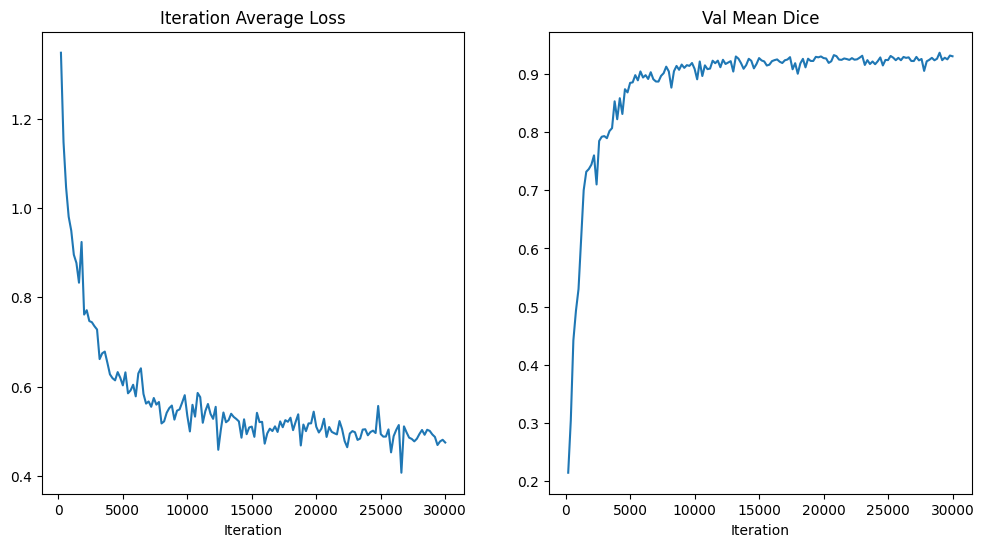

In [11]:

plt.figure("train", (12, 6))
plt.subplot(1, 2, 1)
plt.title("Iteration Average Loss")
x = [eval_num * (i + 1) for i in range(len(epoch_loss_values))]
y = epoch_loss_values
plt.xlabel("Iteration")
plt.plot(x, y)
plt.subplot(1, 2, 2)
plt.title("Val Mean Dice")
x = [eval_num * (i + 1) for i in range(len(metric_values))]
y = metric_values
plt.xlabel("Iteration")
plt.plot(x, y)
plt.show()


In [12]:
print(len(test_ds))

14


### Check best model output with the input image and label

In [ ]:
case_num = 4
#model.load_state_dict(torch.load(os.path.join('C:/Users/Dong/Desktop/Breast_PET_swin_output/lymph_2/', "best_metric_model_30000.pth")))
#weight = torch.load("D:/we/best_metric_model_30000.pth")
#model.load_state_dict(weight)
#print("Using pretrained model weights from C:/Users/Dong/AppData/Local/Temp/tmpo3m9v1gj/best_metric_model.pth!")
#model.load_state_dict(torch.load(os.path.join(root_dir, "best_metric_model.pth")))
model.eval()


현재 파일: CT100.nii.gz, 기본 슬라이스: 45
슬라이스 위치가 75로 변경되었습니다.


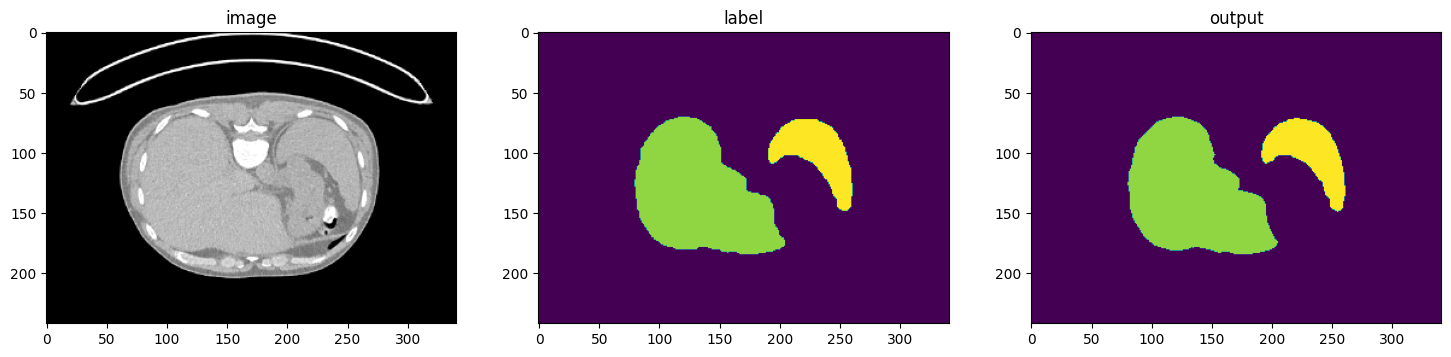

In [29]:
with torch.no_grad():
    img_name = os.path.split(val_ds[case_num]['image'].meta["filename_or_obj"])[1]
    img = val_ds[case_num]["image"]
    label = val_ds[case_num]["label"]
    val_inputs = torch.unsqueeze(img, 1).cuda()
    val_labels = torch.unsqueeze(label, 1).cuda()
    val_outputs = sliding_window_inference(
        val_inputs, (96, 96, 96), 4, model, overlap=0.8
    )

    
    slice_idx = slice_map.get(img_name, 0)
    
    
    print(f"현재 파일: {img_name}, 기본 슬라이스: {slice_idx}")
    custom_slice = input("슬라이스 값을 변경하시겠습니까? (현재 값: {}. 변경하려면 숫자를 입력, 그대로 사용하려면 Enter): ".format(slice_idx))
    if custom_slice.strip():  
        try:
            slice_idx = int(custom_slice)
            print(f"슬라이스 위치가 {slice_idx}로 변경되었습니다.")
        except ValueError:
            print("유효하지 않은 입력입니다. 기본 슬라이스를 사용합니다.")

   
    if slice_idx >= img.shape[3]:
        raise ValueError(f"슬라이스 값 {slice_idx}가 이미지 깊이 {img.shape[3]}를 초과합니다.")

   
    plt.figure("check", (18, 6))
    plt.subplot(1, 3, 1)
    plt.title("image")
    plt.imshow(val_inputs.cpu().numpy()[0, 0, :, :, slice_idx], cmap="gray")
    plt.subplot(1, 3, 2)
    plt.title("label")
    plt.imshow(val_labels.cpu().numpy()[0, 0, :, :, slice_idx])
    plt.subplot(1, 3, 3)
    plt.title("output")
    plt.imshow(
        torch.argmax(val_outputs, dim=1).detach().cpu()[0, :, :, slice_idx]
    )
    plt.show()


현재 파일: CT100.nii.gz, 기본 슬라이스: 45
슬라이스 위치가 75로 변경되었습니다.


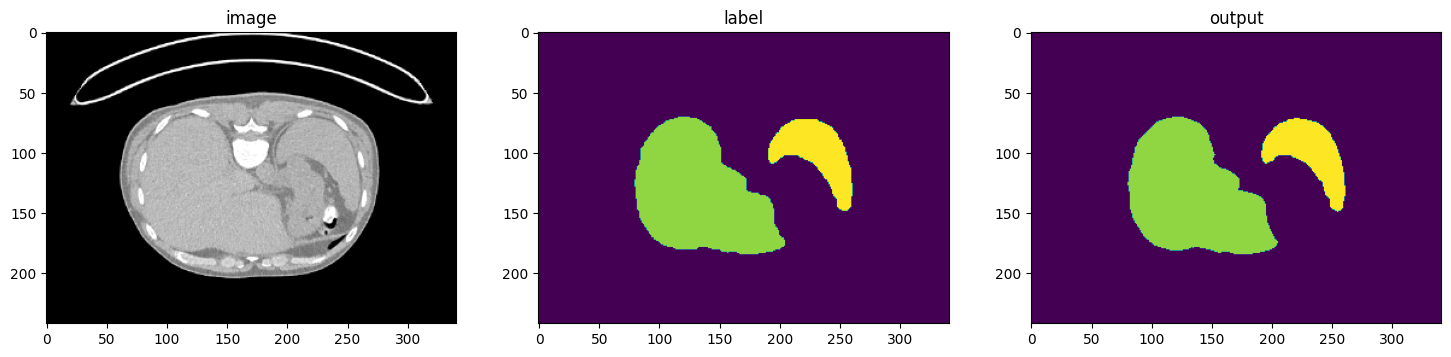


장기별 Dice 계수:
Organ 1: 0.8764
Organ 2: 0.9725
Organ 3: 0.9732
Organ 4: 0.9667
Organ 5: 0.9847
Organ 6: 0.9764
Organ 7: 0.9858


In [ ]:
import torch
import os
import matplotlib.pyplot as plt
from monai.metrics import compute_dice

with torch.no_grad():
    img_name = os.path.split(val_ds[case_num]['image'].meta["filename_or_obj"])[1]
    img = val_ds[case_num]["image"]
    label = val_ds[case_num]["label"]
    val_inputs = torch.unsqueeze(img, 1).cuda()
    val_labels = torch.unsqueeze(label, 1).cuda()
    val_outputs = sliding_window_inference(
        val_inputs, (96, 96, 96), 4, model, overlap=0.8
    )

    
    slice_idx = slice_map.get(img_name, 0)

    
    print(f"현재 파일: {img_name}, 기본 슬라이스: {slice_idx}")
    custom_slice = input("슬라이스 값을 변경하시겠습니까? (현재 값: {}. 변경하려면 숫자를 입력, 그대로 사용하려면 Enter): ".format(slice_idx))
    if custom_slice.strip():  
        try:
            slice_idx = int(custom_slice)
            print(f"슬라이스 위치가 {slice_idx}로 변경되었습니다.")
        except ValueError:
            print("유효하지 않은 입력입니다. 기본 슬라이스를 사용합니다.")

    
    if slice_idx >= img.shape[3]:
        raise ValueError(f"슬라이스 값 {slice_idx}가 이미지 깊이 {img.shape[3]}를 초과합니다.")

    
    plt.figure("check", (18, 6))
    plt.subplot(1, 3, 1)
    plt.title("image")
    plt.imshow(val_inputs.cpu().numpy()[0, 0, :, :, slice_idx], cmap="gray")
    plt.subplot(1, 3, 2)
    plt.title("label")
    plt.imshow(val_labels.cpu().numpy()[0, 0, :, :, slice_idx])
    plt.subplot(1, 3, 3)
    plt.title("output")
    plt.imshow(
        torch.argmax(val_outputs, dim=1).detach().cpu()[0, :, :, slice_idx]
    )
    plt.show()

    
    val_outputs_argmax = torch.argmax(val_outputs, dim=1).detach().cpu()
    val_labels_cpu = val_labels.cpu()
    organ_dice_scores = {}

    
    for organ_id in range(1, val_labels_cpu.max().int() + 1):  # 클래스 1부터 최대 값까지
        organ_output = (val_outputs_argmax == organ_id).float()
        organ_label = (val_labels_cpu == organ_id).float()
        dice_score = compute_dice(organ_output.unsqueeze(0), organ_label.unsqueeze(0), include_background=False)
        organ_dice_scores[f"Organ {organ_id}"] = dice_score.item()

    
    print("\n장기별 Dice 계수:")
    for organ, score in organ_dice_scores.items():
        print(f"{organ}: {score:.4f}")

In [19]:
import nibabel as nib
import numpy as np
from skimage.transform import resize
import time
dice_metric = DiceMetric(include_background=True, reduction="mean", get_not_nans=False)
label_num = 5
post_label = AsDiscrete(to_onehot=label_num)
post_pred = AsDiscrete(argmax=True, to_onehot=label_num)
path_output = 'D:/Lymph_onco_results_save/output_brain'
path_png = 'D:/Lymph_onco_results_save/png_brain'
case_num = 4
#model.load_state_dict(torch.load(os.path.join('C:/Users/Dong/AppData/Local/Temp/tmpo3m9v1gj/', "best_metric_model.pth")))
model.load_state_dict(torch.load(os.path.join(root_dir, "best_metric_model.pth")))
#model.load_state_dict(torch.load(os.path.join('C:/Users/Dong/Desktop/Breast_PET_swin_output/lymph_2/', "best_metric_model_30000.pth")))
#model.load_state_dict(torch.load(os.path.join('C:/Users/joonil/Desktop/연구과제/Auto segmentation/data/code/tutorials-main/tutorials-main/3d_segmentation/result/finish/', "best_metric_model.pth")))
#model.load_state_dict(torch.load(os.path.join('C:/Users/Dong/Desktop/Breast_PET_swin_output/Breast_liver_spleen/', "best_metric_model.pth")))
model.eval()
k = 1
#path = './data/test/CBCT'
print(test_ds[0]['image'].meta['spatial_shape'])
print(test_ds[0]['foreground_start_coord'])
print(test_ds[0]['image'].applied_operations[2]['orig_size'])
test_dice=0
test_dice_1 = 0
test_dice_2 = 0
test_dice_3 = 0
test_dice_4 = 0
test_dice_5 = 0
tic = 0
test_final = 0
with torch.no_grad():
    #img_name = os.path.split(val_ds[case_num]['image'].meta["filename_or_obj"])[1]
    for i in range(len(test_ds)):
        sub_index = i
        img = test_ds[sub_index]["image"]
        label = test_ds[sub_index]["label"]
        val_inputs = torch.unsqueeze(img, 1).cuda()
        val_labels = torch.unsqueeze(label, 1).cuda()
        x = test_ds[sub_index]['foreground_start_coord'][0]
        y = test_ds[sub_index]['foreground_start_coord'][1]
        z = test_ds[sub_index]['foreground_start_coord'][2]
        x_len = test_ds[sub_index]['image'].applied_operations[2]['orig_size'][0]
        y_len = test_ds[sub_index]['image'].applied_operations[2]['orig_size'][1]
        z_len = test_ds[sub_index]['image'].applied_operations[2]['orig_size'][2]
        output = np.zeros((1,label_num,test_ds[sub_index]['image'].meta['spatial_shape'][0],test_ds[sub_index]['image'].meta['spatial_shape'][1],test_ds[sub_index]['image'].meta['spatial_shape'][2]))
        output_temp = np.zeros((label_num,test_ds[sub_index]['image'].meta['spatial_shape'][0],test_ds[sub_index]['image'].meta['spatial_shape'][1],test_ds[sub_index]['image'].meta['spatial_shape'][2]))
        output1 = np.zeros((val_labels.size()[2],val_labels.size()[3],val_labels.size()[4]))
        output2 = np.zeros((val_labels.size()[2],val_labels.size()[3],val_labels.size()[4]))
        val_outputs = sliding_window_inference(
                val_inputs, (96, 96, 96), 4, model, overlap=0.8
        )
        val_outputs_list = decollate_batch(val_outputs)
        val_output_convert = [
            post_pred(val_pred_tensor) for val_pred_tensor in val_outputs_list
        ]
        print(val_output_convert[0].size())
        for j in range(label_num):
            output1 = val_output_convert[0].cpu().numpy()[j,:,:,:]
            output_s_1 = resize(output1, test_ds[sub_index]['image'].applied_operations[2]['orig_size'],order=1)
            output_temp[j,x-1:x+x_len-1,y:y+y_len,z:z+z_len] = output_s_1
        output[0,:,:,:,:] = output_temp
        input = np.zeros(test_ds[sub_index]['image'].meta['spatial_shape'])
        label_temp = np.zeros((label_num,test_ds[sub_index]['image'].meta['spatial_shape'][0],test_ds[sub_index]['image'].meta['spatial_shape'][1],test_ds[sub_index]['image'].meta['spatial_shape'][2]))
        val_labels_list = decollate_batch(val_labels)
        val_labels_convert = [post_label(val_label_tensor) for val_label_tensor in val_labels_list]
        input_s = resize(val_inputs.cpu().numpy()[0,0,:,:,:], test_ds[sub_index]['image'].applied_operations[2]['orig_size'],order=1)
        input[x-1:x+x_len-1,y:y+y_len,z:z+z_len]= input_s
        for j in range(label_num):
            label_s_1 = resize(val_labels_convert[0].cpu().numpy()[j,:,:,:], test_ds[sub_index]['image'].applied_operations[2]['orig_size'],order=1)
            
            label_temp[j,x-1:x+x_len-1,y:y+y_len,z:z+z_len] = label_s_1
            
            label_1 = label_temp[j,:,:,:]
            label_1[label_1>0]=1

            output_1 = output[0,j,:,:,:]
            output_1[output_1>0]=1

            mean_dice_val = np.sum(label_1[output_1==1])*2.0/(np.sum(label_1)+np.sum(output_1))

            
            if j ==0:
                test_dice_1 += mean_dice_val
            elif j==1:
                test_dice_2 += mean_dice_val
            elif j == 2:
                test_dice_3 += mean_dice_val
            elif j == 3:
                test_dice_4 += mean_dice_val
            elif j == 4:
                test_dice_5 += mean_dice_val
                
           
        label = np.zeros((1,1,test_ds[sub_index]['image'].meta['spatial_shape'][0],test_ds[sub_index]['image'].meta['spatial_shape'][1],test_ds[sub_index]['image'].meta['spatial_shape'][2]))
        #label_temp[label_temp>=0.5]=1
        #label_temp[label_temp<0.5]=0
        label[0,0,:,:,:] = np.argmax(label_temp,axis=0)
        val_labels_list = decollate_batch(torch.from_numpy(label))
        val_labels_convert = [post_label(val_label_tensor) for val_label_tensor in val_labels_list]
        #print(val_labels_list[0])
        #output[output>=0.5]=1
        #output[output<0.5]=0
        val_outputs_list = decollate_batch(torch.from_numpy(output))
        val_output_convert = [
            post_pred(val_pred_tensor) for val_pred_tensor in val_outputs_list
        ]
        dice_metric(y_pred=val_output_convert, y=val_labels_convert)
        mean_dice_val = dice_metric.aggregate().item()
        test_dice_1 = mean_dice_val
        test_dice +=mean_dice_val
        print(mean_dice_val)
        dice_metric.reset()
        #print(label.shape)
        label_temp = label[0,0,:,:,:]
        output_temp = np.argmax(output[0,:,:,:,:], axis=0)
        output_temp = np.float64(output_temp)

        
        for j in range(input.shape[2]):
            plt.figure("check", (18, 6))
            plt.subplot(1, 2, 1)
            plt.title("CBCT+label")
            plt.imshow(input[:,:,j], cmap="gray", vmin=0, vmax=1)
            plt.imshow(label_temp[:,:,j],cmap="gray",alpha=0.5)
            plt.subplot(1, 2, 2)
            plt.title("CBCT+output")
            plt.imshow(input[:,:,j], cmap="gray", vmin=0, vmax=1)
            plt.imshow(output_temp[:,:,j],cmap="gray",alpha=0.5)
            name_sub = 'patient' + str(i+1).zfill(4)+'_'+str(j+1).zfill(4)
            sub_dir = os.path.join(path_png,name_sub)
            plt.savefig(sub_dir)
            #plt.show()
            plt.clf()
        name = 'patient'+str(i+1).zfill(4)
        img_input = nib.Nifti1Image(input,None)
        img_input.header.get_xyzt_units()
        img_input.to_filename(os.path.join(path_output,'input'+name+'.nii.gz'))
        img_label = nib.Nifti1Image(label_temp,None)
        img_label.header.get_xyzt_units()
        img_label.to_filename(os.path.join(path_output,'label'+name+'.nii.gz'))
        img_label = nib.Nifti1Image(output_temp,None)
        img_label.header.get_xyzt_units()
        img_label.to_filename(os.path.join(path_output,'output'+name+'.nii.gz'))
        
    print("mmmmmmmmm")
    print(test_dice_1/len(test_ds))
    print(test_dice_2 / len(test_ds))
    print(test_dice_3 / len(test_ds))
    print(test_dice_4 / len(test_ds))
    print(test_dice_5 / len(test_ds))

[512 512 426]
[98  5  0]
(374, 504, 426)
torch.Size([5, 250, 336, 214])


RuntimeError: CUDA error: device-side assert triggered
CUDA kernel errors might be asynchronously reported at some other API call,so the stacktrace below might be incorrect.
For debugging consider passing CUDA_LAUNCH_BLOCKING=1.

In [ ]:
import nibabel as nib
import numpy as np
from skimage.transform import resize
import time
dice_metric = DiceMetric(include_background=True, reduction="mean", get_not_nans=False)
label_num = 5
post_label = AsDiscrete(to_onehot=label_num)
post_pred = AsDiscrete(argmax=True, to_onehot=label_num)
path_output = 'C:/Users/Dong\Desktop/Breast_PET_swin_output/lymph_2/output'
path_png = 'C:/Users/Dong/Desktop/Breast_PET_swin_output/lymph_2/png'
case_num = 4

model.load_state_dict(torch.load(os.path.join(root_dir, "best_metric_model.pth")))
#model.load_state_dict(torch.load(os.path.join('C:/Users/Dong/Desktop/Breast_PET_swin_output/lymph_2/', "best_metric_model_30000.pth")))
#model.load_state_dict(torch.load(os.path.join('C:/Users/joonil/Desktop/연구과제/Auto segmentation/data/code/tutorials-main/tutorials-main/3d_segmentation/result/finish/', "best_metric_model.pth")))
#model.load_state_dict(torch.load(os.path.join('C:/Users/Dong/Desktop/Breast_PET_swin_output/Breast_liver_spleen/', "best_metric_model.pth")))
model.eval()
k = 1
#path = './data/test/CBCT'

print(test_ds[0]['image'].meta['spatial_shape'])
print(test_ds[0]['foreground_start_coord'])
print(test_ds[0]['image'].applied_operations[2]['orig_size'])
test_dice=0
test_dice_1 = 0
tic = 0
test_final = 0
with torch.no_grad():
    #img_name = os.path.split(val_ds[case_num]['image'].meta["filename_or_obj"])[1]
    for i in range(len(test_ds)):
        sub_index = i
        img = test_ds[sub_index]["image"]
        label = test_ds[sub_index]["label"]
        val_inputs = torch.unsqueeze(img, 1).cuda()
        val_labels = torch.unsqueeze(label, 1).cuda()
        x = test_ds[sub_index]['foreground_start_coord'][0]
        y = test_ds[sub_index]['foreground_start_coord'][1]
        z = test_ds[sub_index]['foreground_start_coord'][2]
        x_len = test_ds[sub_index]['image'].applied_operations[2]['orig_size'][0]
        y_len = test_ds[sub_index]['image'].applied_operations[2]['orig_size'][1]
        z_len = test_ds[sub_index]['image'].applied_operations[2]['orig_size'][2]
        output = np.zeros((1,label_num,test_ds[sub_index]['image'].meta['spatial_shape'][0],test_ds[sub_index]['image'].meta['spatial_shape'][1],test_ds[sub_index]['image'].meta['spatial_shape'][2]))
        output_temp = np.zeros((label_num,test_ds[sub_index]['image'].meta['spatial_shape'][0],test_ds[sub_index]['image'].meta['spatial_shape'][1],test_ds[sub_index]['image'].meta['spatial_shape'][2]))

        output1 = np.zeros((val_labels.size()[2],val_labels.size()[3],val_labels.size()[4]))
        output2 = np.zeros((val_labels.size()[2],val_labels.size()[3],val_labels.size()[4]))
        val_outputs = sliding_window_inference(
                val_inputs, (96, 96, 96), 4, model, overlap=0.8
        )

        val_outputs_list = decollate_batch(val_outputs)
        val_output_convert = [
            post_pred(val_pred_tensor) for val_pred_tensor in val_outputs_list
        ]
        

        for j in range(label_num):
            output1 = val_output_convert[0].cpu().numpy()[j,:,:,:]
            output_s_1 = resize(output1, test_ds[sub_index]['image'].applied_operations[2]['orig_size'],order=1)
            output_temp[j,x-1:x+x_len-1,y:y+y_len,z:z+z_len] = output_s_1
        output[0,:,:,:,:] = output_temp


        input = np.zeros(test_ds[sub_index]['image'].meta['spatial_shape'])

        label_temp = np.zeros((label_num,test_ds[sub_index]['image'].meta['spatial_shape'][0],test_ds[sub_index]['image'].meta['spatial_shape'][1],test_ds[sub_index]['image'].meta['spatial_shape'][2]))
        val_labels_list = decollate_batch(val_labels)
        val_labels_convert = [post_label(val_label_tensor) for val_label_tensor in val_labels_list]
        input_s = resize(val_inputs.cpu().numpy()[0,0,:,:,:], test_ds[sub_index]['image'].applied_operations[2]['orig_size'],order=1)
        input[x-1:x+x_len-1,y:y+y_len,z:z+z_len]= input_s
        

        for j in range(label_num):
            label_s_1 = resize(val_labels_convert[0].cpu().numpy()[j,:,:,:], test_ds[sub_index]['image'].applied_operations[2]['orig_size'],order=1)
            label_temp[j,x-1:x+x_len-1,y:y+y_len,z:z+z_len] = label_s_1
        

        label = np.zeros((1,1,test_ds[sub_index]['image'].meta['spatial_shape'][0],test_ds[sub_index]['image'].meta['spatial_shape'][1],test_ds[sub_index]['image'].meta['spatial_shape'][2]))

        #label_temp[label_temp>=0.5]=1
        #label_temp[label_temp<0.5]=0
        label[0,0,:,:,:] = np.argmax(label_temp,axis=0)
        val_labels_list = decollate_batch(torch.from_numpy(label))
        val_labels_convert = [post_label(val_label_tensor) for val_label_tensor in val_labels_list]
        #print(val_labels_list[0])
        #output[output>=0.5]=1
        #output[output<0.5]=0
        val_outputs_list = decollate_batch(torch.from_numpy(output))
        val_output_convert = [
            post_pred(val_pred_tensor) for val_pred_tensor in val_outputs_list
        ]
        dice_metric(y_pred=val_output_convert, y=val_labels_convert)
        mean_dice_val = dice_metric.aggregate().item()
        test_dice_1 = mean_dice_val
        test_dice +=mean_dice_val
        print(mean_dice_val)
        dice_metric.reset()
        
        
        #print(label.shape)
        label_temp = label[0,0,:,:,:]
        output_temp = np.argmax(output[0,:,:,:,:], axis=0)
        output_temp = np.float64(output_temp)

        
        for j in range(input.shape[2]):
            plt.figure("check", (18, 6))
            plt.subplot(1, 2, 1)
            plt.title("CBCT+label")
            plt.imshow(input[:,:,j], cmap="gray", vmin=0, vmax=1)
            plt.imshow(label_temp[:,:,j],cmap="gray",alpha=0.5)
            plt.subplot(1, 2, 2)
            plt.title("CBCT+output")
            plt.imshow(input[:,:,j], cmap="gray", vmin=0, vmax=1)
            plt.imshow(output_temp[:,:,j],cmap="gray",alpha=0.5)
            name_sub = 'patient' + str(i+1).zfill(4)+'_'+str(j+1).zfill(4)
            sub_dir = os.path.join(path_png,name_sub)
            plt.savefig(sub_dir)
            #plt.show()
            plt.clf()
        name = 'patient'+str(i+1).zfill(4)
        img_input = nib.Nifti1Image(input,None)
        img_input.header.get_xyzt_units()
        img_input.to_filename(os.path.join(path_output,'input'+name+'.nii.gz'))
        img_label = nib.Nifti1Image(label_temp,None)
        img_label.header.get_xyzt_units()
        img_label.to_filename(os.path.join(path_output,'label'+name+'.nii.gz'))
        img_label = nib.Nifti1Image(output_temp,None)
        img_label.header.get_xyzt_units()
        img_label.to_filename(os.path.join(path_output,'output'+name+'.nii.gz'))

        
    print("mmmmmmmmm")

In [ ]:
print(mean_dice_val)
print(test_ds[sub_index]['image'].applied_operations[2]['orig_size'])
print(z)

### Cleanup data directory

Remove directory if a temporary was used.

In [ ]:
if directory is None:
    shutil.rmtree(root_dir)